# Synthetic error injection

## Load the 3 grams dataset

In [1]:
import pandas as pd
import random
from tqdm import tqdm_notebook as tqdm

In [2]:
import sys
sys.path.insert(0, "../")

In [3]:
df = pd.read_csv('../three_grams.csv')
df.head(10)

,token_1,ws,token_2,count
0,Comment,1_NL,Comment,3282
1,Comment,1_NL,package,492
2,package,1_SP,Identifier,2083
3,Identifier,0_SP,.,135330
4,.,0_SP,Identifier,146617
5,Identifier,0_SP,;,28148
6,;,1_NL,EOF,4
7,;,2_NL,import,2961
8,import,1_SP,Identifier,15630
9,;,1_NL,import,13795


In [4]:
count_df = df.loc[:,['token_1', 'token_2', 'count']].groupby(['token_1', 'token_2']).agg(['count', 'sum'])

In [5]:
count = count_df['count']['count']
good_for_insertion = list(count[count>=2].index)

In [6]:
good_for_insertion_index = []
for index, (token_1, token_2) in df.loc[:,['token_1', 'token_2']].iterrows():
    if (token_1, token_2) in good_for_insertion:
        good_for_insertion_index.append(index)

In [7]:
good_for_insertion_df = df.iloc[good_for_insertion_index ,:]

In [8]:
good_for_insertion_set = set(
    good_for_insertion
)
def is_good_for_insertion(token_a, token_b):
    return (token_a, token_b) in good_for_insertion_set

In [9]:
def list_alternatives_with_probability(token_a, ws, token_b):
    df_token_1 = good_for_insertion_df[good_for_insertion_df.token_1 == token_a]
    df_token_1_and_2 = df_token_1[df_token_1.token_2 == token_b]
    final = df_token_1_and_2[df_token_1_and_2.ws != ws]
    total = final['count'].sum()
    return {
        ws:count/total
        for _, (_, ws, _, count) in final.iterrows()
    }

In [10]:
list_alternatives_with_probability('Comment', '1_NL', 'Comment')

{'2_NL': 0.6451612903225806,
 '2_NL_4_ID': 0.13978494623655913,
 '1_NL_8_ID': 0.010752688172043012,
 '3_NL': 0.010752688172043012,
 '1_NL_16_DD': 0.010752688172043012,
 '1_NL_4_DD': 0.053763440860215055,
 '2_NL_4_DD': 0.03225806451612903,
 '1_NL_8_DD': 0.03225806451612903,
 '2_NL_8_ID': 0.010752688172043012,
 '2_NL_8_DD': 0.010752688172043012,
 '1_NL_12_ID': 0.010752688172043012,
 '1_NL_2_ID': 0.010752688172043012,
 '1_NL_50_ID': 0.021505376344086023}

## Generation of a new source 

In [11]:
import java_lang_utils as jlu
from core import *

In [12]:
from ml import get_token_value, get_space_value
from token_utils import whitespace_token_to_tuple

In [13]:
from Corpus import Corpus

In [14]:
corpus = Corpus('../corpora/repairnator-corpus/', 'repairnator')

In [15]:
tokenizer = jlu.Tokenizer()
tokenizer_absolute = jlu.Tokenizer(relative=False)

In [16]:
file_dir = corpus.files[10][2]
file_dir

'../corpora/repairnator-corpus/data/51/MavenHelper.java'

In [17]:
original_source = open_file(file_dir)

In [18]:
def pick_random(alternatives):
    random_number = random.random()
    probability_sum = 0
    for alternative, probability in alternatives.items():
        probability_sum += probability
        if random_number <= probability_sum:
            return alternative
    return None

In [19]:
def get_line_indent(line):
    indent = 0
    for c in line:
        if c == ' ':
            indent+=1
        else:
            return indent

In [51]:
def modify_source(source, n_insertion=1):
    tokenized_source = tokenizer.tokenize(source)
    tokenized_source_absolute = tokenizer_absolute.tokenize(source)
    insertion_spots = list(range(len(tokenized_source.tokens)-1))
    random.shuffle(insertion_spots)
    modification = None
    for spot in insertion_spots:
        token_a = tokenized_source.tokens[spot]
        token_b = tokenized_source.tokens[spot+1]
        ws = tokenized_source.white_spaces[spot]
        if is_good_for_insertion(get_token_value(token_a), get_token_value(token_b)):
            alternatives = list_alternatives_with_probability(
                get_token_value(token_a),
                get_space_value(ws),
                get_token_value(token_b)
            )
            alternative_selected = pick_random(alternatives)
            alternative_selected_tuple = whitespace_token_to_tuple(alternative_selected)
            new_ws = tokenized_source_absolute.white_spaces[spot]
            if alternative_selected_tuple[0] == 0:
                new_ws = alternative_selected_tuple
            elif alternative_selected_tuple[0] != 0 and new_ws[0] == 0:
                line = token_a.position[0]
                indent = get_line_indent(source.split('\n')[line-1])
                new_ws = (alternative_selected_tuple[0], indent + alternative_selected_tuple[1])
            else:
                new_ws = (alternative_selected_tuple[0], new_ws[1] + (alternative_selected_tuple[1] - ws[1]))
            if new_ws[1]>=0:
                tokenized_source_absolute.white_spaces[spot] = new_ws
                modification = {
                    'token_a': get_token_value(token_a),
                    'token_b': get_token_value(token_b),
                    'modification': (get_space_value(ws), alternative_selected),
                    'position': spot
                }
                break
    return tokenized_source_absolute.reformat(), modification

In [49]:
injection_operator_types={
    'insertion-space': (1,0,0,0,0),
    'insertion-tab': (0,1,0,0,0),
    'insertion-newline': (0,0,1,0,0),
    'deletion-space': (0,0,0,1,0),
    'deletion-newline': (0,0,0,0,1)
}
injection_operator_pool = [
    'insertion-space',
    'insertion-tab',
    'insertion-newline',
    'deletion-space',
    'deletion-newline',
    'insertion-space',
    'insertion-newline',
    'deletion-space',
    'deletion-newline',
    'insertion-space',
    'insertion-newline',
    'deletion-space',
    'deletion-newline'
]

class InsertionException(Exception):
    pass

def modify_source(source):
    if not jlu.check_source_well_formed(source):
        raise InsertionException
    while True:
        injection_operation = random.choice(injection_operator_pool)
        ugly_content, modification = jlu.gen_ugly_from_source(source, modification_number=injection_operator_types[injection_operation])
        if not jlu.check_source_well_formed(ugly_content):
            continue
        spaces_original, tokens_original = jlu.tokenize_with_white_space(source)
        spaces_errored, tokens_errored = jlu.tokenize_with_white_space(ugly_content)
        if len(tokens_original) != len(tokens_errored):
            continue
        return ugly_content, (modification, injection_operation)

In [22]:
t = tokenizer_absolute.tokenize(original_source)

In [23]:
def diff(file_A, file_B, unified=True):
    if unified:
        cmd = 'diff -u {} {}'.format(file_A, file_B)
    else:
        cmd = 'diff {} {}'.format(file_A, file_B)
    process = subprocess.Popen(cmd.split(" "), stdout=subprocess.PIPE)
    output = process.communicate()[0]
    return output.decode("utf-8")

In [24]:
modified_source, _ = modify_source(original_source)
file_A = save_file('./tmp/', 'orig.java', original_source)
file_B = save_file('./tmp/', 'modif.java', modified_source)
print(diff(file_A, file_B))

--- ./tmp/orig.java	2019-10-10 10:37:10.000000000 -0400
+++ ./tmp/modif.java	2019-10-10 10:37:10.000000000 -0400
@@ -56,8 +56,7 @@
         if (enableHandlers) {
             this.errorHandler = new MavenErrorHandler(this.inspector, this.name);
             this.outputHandler = new MavenFilterOutputHandler(this.inspector, this.name);
-        } else {
-            this.outputHandler = new MavenMuteOutputHandler(this.inspector, this.name);
+        } else {            this.outputHandler = new MavenMuteOutputHandler(this.inspector, this.name);
         }
     }
 
@@ -115,3 +114,4 @@
         }
     }
 }
+



## Generation of errors

### Batches

In [25]:
import uuid
import checkstyle
import shutil

In [42]:
corpus_name = 'be5'

In [43]:
corpus = Corpus(f'../corpora/{corpus_name}-corpus/', corpus_name)
BATCH_SIZE = 500

In [40]:
share = {
    'learning': 0.8,
    'validation': 0.1,
    'testing': 0.1
}

In [29]:
def split_files(corpus, share, random_state=100):
    files_list = [file for (_,_,file) in corpus.files.values()]
    n_files = len(files_list)
    random.seed(random_state)
    random.shuffle(files_list)
    c_learning = int(share['learning']*n_files)
    c_validation = int(share['validation']*n_files)
    return {
        'learning': files_list[:c_learning],
        'validation': files_list[c_learning: c_learning+c_validation],
        'testing': files_list[c_learning+c_validation:]
    }

In [30]:
class Batch:
    def __init__(self, files_dir, checkstyle_dir, batch_id=None):
        self.checkstyle_dir = checkstyle_dir
        if batch_id == None:
            self.batch_id = uuid.uuid4().hex
        else:
            self.batch_id = batch_id
        self.batch_files = [random.choice(files_dir) for _ in range(BATCH_SIZE)]
        self.batch_dir = f'./tmp/{self.batch_id}'
    
    def gen(self):
        create_dir(self.batch_dir)
        self.batch_injections = {}
        for index, file_dir in tqdm(enumerate(self.batch_files), total=BATCH_SIZE):
            file_name = file_dir.split('/')[-1]
            original_source = open_file(file_dir)
            try:
                modified_source, modification = modify_source(original_source)
            except InsertionException:
                continue
            modification_folder = os.path.join(self.batch_dir, str(index))
            create_dir(modification_folder)
            modified_file_dir = save_file(modification_folder, file_name, modified_source)
            
            diff_str = diff(file_dir, modified_file_dir)
            diff_path = save_file(modification_folder, 'diff.diff', diff_str)
            self.batch_injections[index] = {
                'modification': modification,
                'diff': diff_str,
                'dir': modification_folder,
                'orig': file_dir,
                'file_name': file_name
            }
        self.checkstyle_result, _ = checkstyle.check(
            self.checkstyle_dir,
            self.batch_dir,
            checkstyle_jar="../../jars/checkstyle-8.12-all.jar",
            only_java=True
        )
        for file_dir, res in self.checkstyle_result.items():
            index = int(file_dir.split('/')[-2])
            self.batch_injections[index]['errors'] = res['errors']
            save_json(self.batch_injections[index]['dir'], 'errors.json', res['errors'])
        self.batch_information = {
            'batch_id': self.batch_id,
            'injection_report': self.batch_injections
        }
        save_json(self.batch_dir, 'metadata.json', self.batch_information)
        return self.batch_information
    
    def clean(self):
        shutil.rmtree(self.batch_dir)

In [31]:
corpus.checkstyle

'../corpora/dagger-corpus/checkstyle.xml'

In [32]:
batch = Batch(split_files(corpus, share)['learning'], corpus.checkstyle)

In [75]:
batch_res = batch.gen();



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:22,  4.31it/s]

  8%|▊         | 8/100 [00:00<00:15,  5.98it/s]

 14%|█▍        | 14/100 [00:00<00:10,  8.16it/s]

 20%|██        | 20/100 [00:00<00:07, 10.95it/s]

 24%|██▍       | 24/100 [00:00<00:05, 13.31it/s]

 28%|██▊       | 28/100 [00:00<00:04, 16.58it/s]

 32%|███▏      | 32/100 [00:01<00:04, 16.86it/s]

 38%|███▊      | 38/100 [00:01<00:03, 20.04it/s]

 42%|████▏     | 42/100 [00:01<00:02, 19.65it/s]

 45%|████▌     | 45/100 [00:01<00:03, 16.47it/s]

 49%|████▉     | 49/100 [00:01<00:02, 19.82it/s]

 54%|█████▍    | 54/100 [00:01<00:02, 21.40it/s]

 60%|██████    | 60/100 [00:02<00:01, 26.23it/s]

 64%|██████▍   | 64/100 [00:02<00:01, 25.56it/s]

 69%|██████▉   | 69/100 [00:02<00:01, 29.80it/s]

 75%|███████▌  | 75/100 [00:02<00:00, 34.21it/s]

 82%|████████▏ | 82/100 [00:02<00:00, 39.88it/s]

 87%|████████▋ | 87/100 [00:02<00:00, 29.19it/s]

 91%|█████████ | 91/100 [00:03<00:00, 25.61it/s]

 95%|████

In [76]:
errors_type = [
    info['errors'][0]['source'].split('.')[-1] 
    for info in batch_res['injection_report'].values() 
    if len(info['errors']) == 1
]

In [77]:
print(f'total number of files with a single errors {len(errors_type)} ()')

total number of files with a single errors 30 ()


In [78]:
from collections import Counter

In [79]:
error_type_count = Counter(errors_type)
error_type_count

Counter({'FileTabCharacterCheck': 13,
         'ParenPadCheck': 1,
         'WhitespaceAroundCheck': 5,
         'LineLengthCheck': 2,
         'WhitespaceAfterCheck': 2,
         'RegexpSinglelineCheck': 3,
         'MethodParamPadCheck': 3,
         'LeftCurlyCheck': 1})

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
col_names, values = tuple(zip(*list(error_type_count.items())))

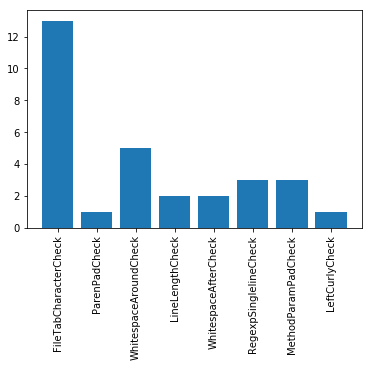

In [82]:
fig = plt.figure()

y_pos = list(range((len(col_names))))

plt.bar(y_pos, values)

plt.xticks(y_pos, col_names,rotation='vertical')

plt.show()

### Dataset

In [44]:
from tqdm import tqdm_notebook as tqdm
def gen_errors(files_dir, checkstyle_dir, target, number_of_errors):
    valid_errors = []
    batches = []
    with tqdm(total=number_of_errors) as pbar:
        while len(valid_errors) < number_of_errors:
            batch = Batch(files_dir, checkstyle_dir)
            batches.append(batch)
            try:
                batch_res = batch.gen()
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except: # UnicodeEncodeError
                continue
            batch_valid_errors = [
                info
                for info in batch_res['injection_report'].values() 
                if len(info['errors']) == 1
            ]
            valid_errors += batch_valid_errors
            pbar.update(len(batch_valid_errors))
    selected_errors = random.sample(valid_errors, number_of_errors)
    for error_id, error_metadata in enumerate(selected_errors):
        new_error_dir = os.path.join(target, str(error_id))
        old_dir = error_metadata['dir']
        shutil.move(old_dir, new_error_dir)
        error_metadata['dir'] = new_error_dir
        error_metadata['error'] = error_metadata['errors'][0]
        error_metadata['error']['type'] = checkstyle_source_to_error_type(error_metadata['error']['source'])
        
        file_name = error_metadata['file_name']
        orig_file_name = '.'.join(file_name.split('.')[:-1]) + '-orig.java'
        shutil.copy(error_metadata['orig'], os.path.join(new_error_dir, orig_file_name))
        
        save_json(new_error_dir, 'metadata.json', error_metadata)
    for batch in batches:
        batch.clean()
    return selected_errors

In [34]:
gen_errors(split_files(corpus, share)['learning'], corpus.checkstyle, './tmp/dataset', 1000);

KeyboardInterrupt: 

In [45]:
def gen_dataset(corpus, share, total, target):
    splitted_files = split_files(corpus, share)
    for name, subset_share in share.items():
        gen_errors(splitted_files[name], corpus.checkstyle, os.path.join(target, name), int(subset_share*total))

In [52]:
gen_dataset(corpus, share, 10000, './tmp/dataset/protocol1/' + corpus_name + '_old_new');

In [62]:
split_files(corpus, share)

{'learning': ['../corpora/picasso-corpus/data/9/SampleContactsActivity.java',
  '../corpora/picasso-corpus/data/28/Callback.java',
  '../corpora/picasso-corpus/data/40/PicassoProvider.java',
  '../corpora/picasso-corpus/data/59/OkHttp3DownloaderTest.java',
  '../corpora/picasso-corpus/data/19/AssetRequestHandler.java',
  '../corpora/picasso-corpus/data/7/SampleScrollListener.java',
  '../corpora/picasso-corpus/data/23/GetAction.java',
  '../corpora/picasso-corpus/data/34/OkHttp3Downloader.java',
  '../corpora/picasso-corpus/data/47/Stats.java',
  '../corpora/picasso-corpus/data/31/MarkableInputStream.java',
  '../corpora/picasso-corpus/data/53/UtilsTest.java',
  '../corpora/picasso-corpus/data/50/Cache.java',
  '../corpora/picasso-corpus/data/36/PicassoExecutorService.java',
  '../corpora/picasso-corpus/data/54/TargetActionTest.java',
  '../corpora/picasso-corpus/data/2/SampleGalleryActivity.java',
  '../corpora/picasso-corpus/data/32/Downloader.java',
  '../corpora/picasso-corpus/data